# Amplitude regression

In the lectures you've covered multi-variate analyses, fits and interpolations, and the basics of neural networks.  Here we'll put this into practice by building a neural network in pytorch to perform a regression task on the LHC amplitude for the production of two photons and a gluon in a gluon-gluon collision.

We want to train a network to predict the amplitude for the process $gg\rightarrow\gamma\gamma g$.  So the amplitude depends on the 4-momentum of 5 particles: 2 incoming gluons, 2 outgoing photons, and one outgoing gluon.  

The incoming gluons will have no transverse momentum, but their total momentum along the beam pipe is not necessarily zero.

The network we will train is a simple fully connected dense network.  This means that the input and output can only be vectors of real numbers.  We want to input the kinematic information on the particles to the network, and train the network to output the corresponding amplitude.  So we need to think about how we input our kinematic 4-vectors to the network, this generally depends on the network architecture we are using.

#### Outline / tasks:
 - Imports \& plotting set-up
 - Loading the data
 - Visualising the data
     - visualise some of the kinematics of the process (transverse momentum of photons/gluons, MET)
     - histogram the amplitudes
 - Preprocessing the data
     - neural networks like $\mathcal{O}(1)$ numbers
     - how should we preprocess the data?
 - Datasets and dataloaders
     - details are in the pytorch docs
 - Building the neural network
     - construct a simple neural network with 2 hidden layers with some number of nodes, it's up to you
     - tip: use linear layers followed by relu activations
     - all the relevant details are in the pytorch docs
 - Optimising (training) the neural network
     - create a function to train the network for a single epoch
     - create functions to compute the test and validation loss at the end of an epoch
     - define a loss function (tip: MSE is a good choice)
     - define an optimizer (tip: Adam is a good choice)
     - train the network for some number of epochs
 - Plot the train and validation losses as a function of the epochs
     - to check the the network is training we should plot the train and validation losses as a function of the epochs
 - Study the results
     - beyond the losses, how can we check that our network is making sensible predictions?
 - Can you think of ways to improve your network or your training?  List them!
     
Most practical pytorch skills you need for this work is covered in the basics tutorial at https://pytorch.org/tutorials/beginner/basics/intro.html.

Please download the training data `tutorial-2-data.zip` and extract it to the folder `data/tutorial-2-data/`.

If you want to run this tutorial in google colab, you can open a new colab and then upload this file. 

The data can be downloaded using

```
NEEDS TO BE CHANGED!
!wget -O tutorial-2-data.zip https://www.dropbox.com/s/n5e66w91rgmbqz2/dlpp-data.zip?dl=0&file_subpath=%2Fdlpp-data%2Ftutorial-2-data
!unzip "tutorial-2-data.zip"
!mkdir tutorial-2-data
!mv dlpp-data/tutorial-2-data/* tutorial-2-data/.
!rm -r __MACOSX/
!rm -r dlpp-data/
!ls
```

Make sure you switch to a GPU runtime to fully utilize the colab. 

### Imports

In [1]:
import os
import sys
import random
import time
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

#### Plotting set-up

In [2]:
from matplotlib import pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import matplotlib.colors as mcolors
import colorsys

labelfont = FontProperties()
labelfont.set_family('serif')
labelfont.set_name('Times New Roman')
labelfont.set_size(14)

axislabelfont = FontProperties()
axislabelfont.set_family('serif')
axislabelfont.set_name('Times New Roman')
axislabelfont.set_size(22)

tickfont = FontProperties()
tickfont.set_family('serif')
tickfont.set_name('Times New Roman')
tickfont.set_size(16)

axisfontsize = 16
labelfontsize = 16

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams['text.usetex'] = False # this had to be disabled to work on colab!

## Loading the data

In [3]:
trn_dat = np.load( "data/tutorial-2-data/trn_dat.npy" )
trn_amp = np.load( "data/tutorial-2-data/trn_amp.npy" )

val_dat = np.load( "data/tutorial-2-data/val_dat.npy" )
val_amp = np.load( "data/tutorial-2-data/val_amp.npy" )

tst_dat = np.load( "data/tutorial-2-data/tst_dat.npy" )
tst_amp = np.load( "data/tutorial-2-data/tst_amp.npy" )

In [4]:
print( f"train data shape: {trn_dat.shape}" )
print( f"train amp  shape: {trn_amp.shape}" )
print( f"test  data shape: {tst_dat.shape}" )
print( f"test  amp  shape: {tst_amp.shape}" )
print( f"val   data shape: {val_dat.shape}" )
print( f"val   amp  shape: {val_amp.shape}" )

train data shape: (30000, 5, 4)
train amp  shape: (30000,)
test  data shape: (30000, 5, 4)
test  amp  shape: (30000,)
val   data shape: (30000, 5, 4)
val   amp  shape: (30000,)


The data is organised as follows:
 - the shape corresponds to ( number of events, number of particles, 4-momentum )
 - the particles are arranged as follows
     - the first two entries are the two incoming gluons
     - the next two particles are the outgoing photons
     - the last particle is the outgoing gluon
 - the incoming gluons and incoming photons are arranged by transverse memontum $p_T$

Why is the ordering important?

## Visualising the data

Below we will make some kinematic plots of the events in the training sample.  Note however that these are not the physical distributions we would measure at the LHC!  In our training data each of these events is associated with an amplitude, which tells us the probability that the event will be produced in the gluon-gluon interaction.  So to get the physical distributions these events would need to be 'weighted' by their amplitude.  However, right now we just want to visualise our training dataset to see what preprocessing we should do.

In [5]:
def get_init_pz(ev):
    """ sums z component of incoming particle's momenta"""
    return ev[:, 0, 3] + ev[:, 1, 3]

def get_mass(fv):
    """ gets invariant mass of four vector """
    msq = np.round(fv[:, 0]**2 - fv[:, 1]**2 - fv[:, 2]**2 - fv[:, 3]**2, 5)
    if (msq < 0.).any():
        raise Exception("mass squared is less than zero")
    return np.sqrt(msq)

def get_pt(fv):
    """ returns p_T of given four vector """
    ptsq = np.round(fv[:, 1]**2 + fv[:, 2]**2, 5)
    return np.sqrt(ptsq)

def get_met(fv):
    """ returns MET of the event"""
    return np.abs(np.sum(fv[:, :, 1]+fv[:, :, 2], axis=1))

### Plotting the initial $p_z$ of the events in the training sample.

In [6]:
trn_dat_init_pz = get_init_pz(trn_dat)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


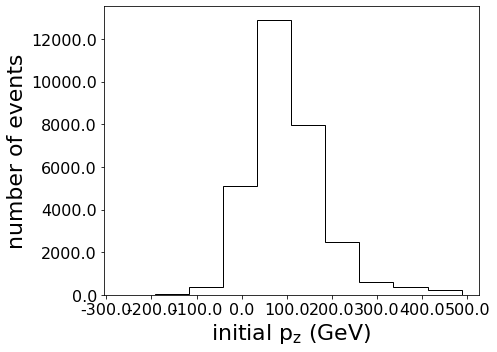

In [7]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

axs.hist(trn_dat_init_pz, histtype='stepfilled', fill=None)

axs.set_xlabel("initial $p_z$ (GeV)", fontproperties=axislabelfont)
axs.set_ylabel("number of events", fontproperties=axislabelfont)

xticks = axs.get_xticks()
axs.set_xticklabels(xticks, fontproperties=tickfont)

yticks = axs.get_yticks()
axs.set_yticklabels(yticks, fontproperties=tickfont)

fig.tight_layout()

### We can plot a histogram of the amplitudes for the training data.

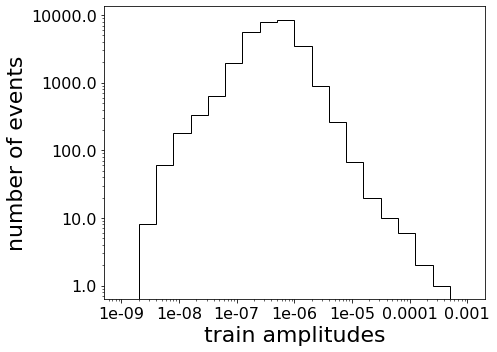

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))
bins=np.logspace(-9, -3, 21)

axs.hist(trn_amp, histtype='stepfilled', fill=None, bins=bins)

axs.set_yscale('log')
axs.set_xscale('log')

axs.set_xlabel("train amplitudes", fontproperties=axislabelfont)
axs.set_ylabel("number of events", fontproperties=axislabelfont)

xticks = axs.get_xticks()
axs.set_xticklabels(xticks, fontproperties=tickfont)

yticks = axs.get_yticks()
axs.set_yticklabels(yticks, fontproperties=tickfont)

fig.tight_layout()

The amplitudes span about 4 orders of magnitude...

### Plotting the leading photon $p_T$.

In [9]:
trn_dat_leading_photon_pt = get_pt(trn_dat[:, 2])

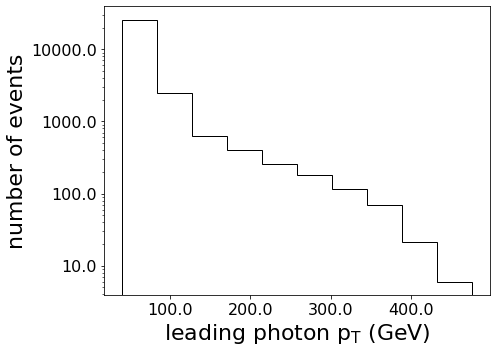

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

axs.hist(trn_dat_leading_photon_pt, histtype='stepfilled', fill=None)

axs.set_yscale('log')

axs.set_xlabel("leading photon $p_T$ (GeV)", fontproperties=axislabelfont)
axs.set_ylabel("number of events", fontproperties=axislabelfont)

xticks = axs.get_xticks()
axs.set_xticklabels(xticks, fontproperties=tickfont)

yticks = axs.get_yticks()
axs.set_yticklabels(yticks, fontproperties=tickfont)

fig.tight_layout()

### Plot the final state gluon $p_T$.

In [11]:
trn_dat_gluon_pt = get_pt(trn_dat[:, 4])

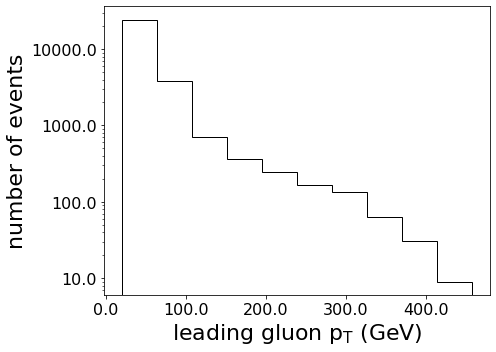

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

axs.hist(trn_dat_gluon_pt, histtype='stepfilled', fill=None)

axs.set_yscale('log')

axs.set_xlabel("leading gluon $p_T$ (GeV)", fontproperties=axislabelfont)
axs.set_ylabel("number of events", fontproperties=axislabelfont)

xticks = axs.get_xticks()
axs.set_xticklabels(xticks, fontproperties=tickfont)

yticks = axs.get_yticks()
axs.set_yticklabels(yticks, fontproperties=tickfont)

fig.tight_layout()

The mean final state gluon $p_T$ in GeV is:

In [13]:
np.mean(trn_dat_gluon_pt)

49.698076969543024

### Plotting the missing transverse energy (MET) for each event.

In [14]:
trn_dat_met = get_met(trn_dat)

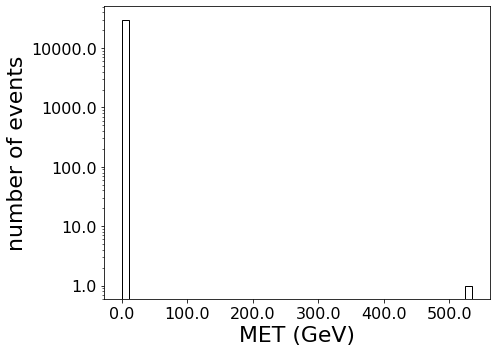

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

axs.hist(trn_dat_met, histtype='stepfilled', fill=None, bins=50)

axs.set_yscale('log')

axs.set_xlabel("MET (GeV)", fontproperties=axislabelfont)
axs.set_ylabel("number of events", fontproperties=axislabelfont)

xticks = axs.get_xticks()
axs.set_xticklabels(xticks, fontproperties=tickfont)

yticks = axs.get_yticks()
axs.set_yticklabels(yticks, fontproperties=tickfont)

fig.tight_layout()

As expected, this is zero for all events (except one, oddly).  We expect this because the incoming gluons have no $p_T$.  

Let's see where this single high MET event arises...

In [16]:
np.where(trn_dat_met > 300)

(array([12127]),)

In [17]:
trn_dat[12127]

array([[ 360.37961003,   96.31550214,  192.63100427,  288.94650641],
       [ 693.71294336, -185.40258277, -370.80516555, -556.20774832],
       [ 506.22226952, -340.95585115, -332.00806946, -172.57095798],
       [ 360.29766015,  277.8398014 ,  214.67663535,   80.82939381],
       [ 187.57262372,  -25.97103088,  -60.84272717, -175.51967775]])

The incoming gluons are not along the beampipe.  This is a bug in the dataset. 1/30k is not such a big deal.

In [18]:
print(get_mass(trn_dat[12127]))

[ 0. -0. -0. -0.  0.]


At least the constituents are massless..

## Preprocessing the data

We will be using a dense network, so the data needs to be in vector format.  We will collapse the data for each event to a single vector of dimension $5\times4=20$.  The fact that the data is ordered here is important.  To predict the amplitude given the kinematics, the network needs to know which entries correspond to which particles in the process.

In [19]:
nev = trn_dat.shape[0]
trn_datf = np.reshape(trn_dat, (nev, -1))
val_datf = np.reshape(val_dat, (nev, -1))
tst_datf = np.reshape(tst_dat, (nev, -1))

Check the shape:

In [20]:
trn_datf.shape

(30000, 20)

There are further preprocessing steps we can take.  For example, the inputs are numerically very large $\mathcal{O}(100)$ and span a large range.  So we could re-scale the inputs by a constant number, or even take the logarithm of the inputs.

For now, we'll just re-scale by a constant number, the average final state gluon $p_T$, assuming that this is a natural scale for the problem.  And we should be careful to preprocess the train, validation, and test data in the exact same way.

In [21]:
gpt = np.mean(trn_dat_gluon_pt)
trn_datf = trn_datf / gpt
val_datf = val_datf / gpt
tst_datf = tst_datf / gpt

Now convert them to pytorch tensors.

In [22]:
trn_datfp = torch.Tensor(trn_datf)
val_datfp = torch.Tensor(val_datf)
tst_datfp = torch.Tensor(tst_datf)

We should also preprocess the amplitude data.  As we seen in a plot above, the amplitudes span about 4 orders of magnitude.  This could be difficult for the network to interpolate.  We can aleviate the problem with preprocessing, taking the logarithm of the amplitudes.

In [23]:
trn_ampl = np.log(trn_amp)
val_ampl = np.log(val_amp)
tst_ampl = np.log(tst_amp)

In [24]:
trn_amplp = torch.Tensor(trn_ampl)
val_amplp = torch.Tensor(val_ampl)
tst_amplp = torch.Tensor(tst_ampl)

In [25]:
torch.mean(val_amplp)

tensor(-14.7285)

The new distribution looks nicer:

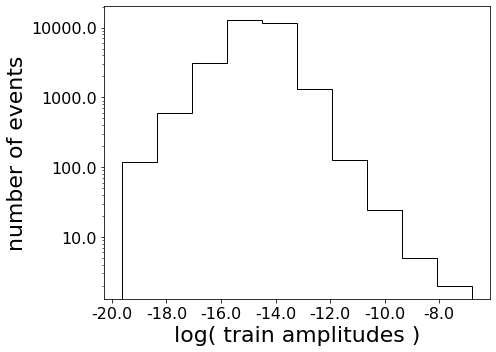

In [26]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

axs.hist(trn_ampl, histtype='stepfilled', fill=None)

axs.set_yscale('log')

axs.set_xlabel("log( train amplitudes )", fontproperties=axislabelfont)
axs.set_ylabel("number of events", fontproperties=axislabelfont)

xticks = axs.get_xticks()
axs.set_xticklabels(xticks, fontproperties=tickfont)

yticks = axs.get_yticks()
axs.set_yticklabels(yticks, fontproperties=tickfont)

fig.tight_layout()

## Datasets and dataloaders

First define a class for the datasets.

In [27]:
class amp_dataset(Dataset):
    
    def __init__(self, data, amp):
        self.data = data
        self.amp = amp

    def __len__(self):
        return len(self.amp)

    def __getitem__(self, idx):
        return self.data[idx], self.amp[idx]

Then initialise them with the data and amplitudes.  We use unsqueeze here so that the shape of the amplitudes matches the shape output from the neural network.

In [28]:
trn_dataset = amp_dataset(trn_datfp, trn_amplp.unsqueeze(-1))
val_dataset = amp_dataset(val_datfp, val_amplp.unsqueeze(-1))
tst_dataset = amp_dataset(tst_datfp, tst_amplp.unsqueeze(-1))

Now we can define a dataloader for each of these datasets.

In [29]:
trn_dataloader = DataLoader(trn_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
tst_dataloader = DataLoader(tst_dataset, batch_size=64, shuffle=True)

We can test our dataloader.

In [30]:
next(iter(trn_dataloader))

[tensor([[ 9.6297,  0.0000,  0.0000,  ..., -2.4521, -2.1777, -7.3092],
         [ 2.9758,  0.0000,  0.0000,  ..., -0.0125, -0.6342,  0.6158],
         [ 6.1968,  0.0000,  0.0000,  ..., -1.1848, -0.6253, -0.4086],
         ...,
         [ 3.7831,  0.0000,  0.0000,  ...,  0.0210, -1.3174,  1.8304],
         [ 2.6111,  0.0000,  0.0000,  ..., -0.5086, -0.2432,  0.3687],
         [ 3.2209,  0.0000,  0.0000,  ...,  0.0237, -0.5485,  0.5321]]),
 tensor([[-13.7241],
         [-14.7717],
         [-15.8737],
         [-14.3233],
         [-13.9979],
         [-14.8040],
         [-14.8984],
         [-15.7233],
         [-15.8669],
         [-13.8611],
         [-13.8924],
         [-16.9355],
         [-14.9823],
         [-13.4239],
         [-17.2864],
         [-13.8684],
         [-15.9591],
         [-15.3762],
         [-13.4690],
         [-14.3441],
         [-13.9576],
         [-17.6547],
         [-15.2321],
         [-14.0603],
         [-15.7789],
         [-15.4317],
         [-1

And we can check that the shape for the kinematic data and amplitudes come out correct.

In [31]:
next(iter(trn_dataloader))[0].shape

torch.Size([64, 20])

In [32]:
next(iter(trn_dataloader))[1].shape

torch.Size([64, 1])

## Building the neural network

We'll build a simple network with one input and one output layer, and two hidden layers.  We define the dimensions of these layers below.

In [33]:
ipt_dim = 20
opt_dim = 1
hdn_dim = 30

Now we build a very simple class for our neural network, which we call amp_net.

In [34]:
class amp_net(nn.Module):
    
    # default hdn_dim is 30, but can be changed upon initialisation
    def __init__(self, hdn_dim=30):
        
        super(amp_net, self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(ipt_dim, hdn_dim),
            nn.ReLU(),
            nn.Linear(hdn_dim, hdn_dim),
            nn.ReLU(),
            nn.Linear(hdn_dim, opt_dim),
        )

    def forward(self, x):
        out = self.linear_relu_stack(x)
        return out

Check if we have a GPU.

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Initialise the neural network and send to the GPU if we have one.  We can also print the model to see what layers it has.

In [36]:
model = amp_net(hdn_dim=hdn_dim).to(device)
print(model)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")

amp_net(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=1, bias=True)
  )
)
Model has 1591 trainable parameters


Now we can test it briefly by throwing some random numbers into it.

In [37]:
X = torch.rand(40, 20, device=device)
model(X)

tensor([[-0.0558],
        [-0.0646],
        [-0.0449],
        [-0.0854],
        [-0.0674],
        [-0.0783],
        [-0.0566],
        [-0.0793],
        [-0.0727],
        [-0.0731],
        [-0.0754],
        [-0.0793],
        [-0.0710],
        [-0.0734],
        [-0.0954],
        [-0.0807],
        [-0.0861],
        [-0.0639],
        [-0.0596],
        [-0.0557],
        [-0.0722],
        [-0.0726],
        [-0.0994],
        [-0.0686],
        [-0.0530],
        [-0.0555],
        [-0.0851],
        [-0.0589],
        [-0.0750],
        [-0.0687],
        [-0.0659],
        [-0.0738],
        [-0.0858],
        [-0.0608],
        [-0.0641],
        [-0.0604],
        [-0.0701],
        [-0.0766],
        [-0.0896],
        [-0.0802]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [38]:
model(X).shape

torch.Size([40, 1])

Looks like it's working.

## Optimising (training) the neural network

We need to decide what function we want the neural network to optimise, i.e. the loss function.  There are a number of choices to decide from, the key point is that the loss function should be minimised when the neural network correctly predicts the amplitude given the kinematical information on the event.  For this we'll use the MSE, the mean squared error.

$\text{MSE} = ( \text{pred_amp} - \text{true_amp} )^2 $

In [39]:
loss_fn = nn.MSELoss()

PyTorch will compute gradients of this loss function with respect to the trainable parameters of the network.  The network is optimised by updating the parameters using the gradients.  The exact scheme to do this is defined by our choice of optimiser.  A standard choice is the Adam optimiser, which we will use here with it's default hyper-parameters.

You can read more about this optimiser here:
 - https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
 - https://arxiv.org/abs/1412.6980

In [40]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

We've already set the batch size when defining the dataloaders.  Below we set the number of epochs, i.e. the number of times we will iterate through the training data to optimise the network.  This means that the total number of updates to the network parameters will be $\simeq\text{size of dataset}\times \text{epochs} / \text{batch size}$.

Now we can write a training loop for a single epoch.

In [41]:
def train_epoch(dataloader, model, loss_fn, optimizer):
    
    size = len(dataloader.dataset)
    
    loss_during_opt = 0.
    
    for batch, (X, y) in enumerate(dataloader):

        # pass data through network
        pred = model(X)
        
        # compute loss
        loss = loss_fn(pred, y)
        loss_during_opt += loss.item()

        # reset gradients in optimizer
        optimizer.zero_grad()
        
        # compute gradients
        loss.backward()
        
        # update weights with optimizer
        optimizer.step()
        
        # print the training loss every 100 updates
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"current batch loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    loss_live = loss_during_opt/len(dataloader)
    print(f"avg train loss per batch in training: {loss_live:>8f}")        
    return loss_live

To monitor the performance of the network on the regression task we want to calculate the loss of both the training data and the validation data on the same network, so we have the following functions:

In [42]:
def val_pass(dataloader, model, loss_fn):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    vl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            vl += loss_fn(pred, y).item()

    vl /= num_batches
    print(f"avg val loss per batch: {vl:>8f}")
    
    return vl

def trn_pass(dataloader, model, loss_fn):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    tl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            tl += loss_fn(pred, y).item()

    tl /= num_batches
    print( f"avg trn loss per batch: {tl:>8f}" )
    
    return tl

Now we can train the model!

In [43]:
# a useful function to present things clearer
def seperator():
    print( "-----------------------------------------------" )

# reset some parameters and move to GPU
batch_size = 128
trn_dataset = amp_dataset(trn_datfp.to(device), trn_amplp.unsqueeze(-1).to(device))
val_dataset = amp_dataset(val_datfp.to(device), val_amplp.unsqueeze(-1).to(device))
tst_dataset = amp_dataset(tst_datfp.to(device), tst_amplp.unsqueeze(-1).to(device))
trn_dataloader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
tst_dataloader = DataLoader(tst_dataset, batch_size=batch_size, shuffle=True)
epochs = 150

# re-initialise the model and the optimizer
hdn_dim = 50
model = amp_net(hdn_dim=hdn_dim).to(device)
learning_rate = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
seperator()
print("model architecture ")
seperator()
print(model)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")

# track train and val losses
trn_losses_live = []
trn_losses = []
val_losses = []

for t in range(epochs):
    seperator()
    print(f"Epoch {t+1}")
    seperator()
    trn_loss_live = train_epoch(trn_dataloader, model, loss_fn, optimizer)
    trn_losses_live.append(trn_loss_live)
    seperator()
    trn_loss = trn_pass(trn_dataloader, model, loss_fn)
    trn_losses.append(trn_loss)
    seperator()
    val_loss = val_pass(val_dataloader, model, loss_fn)
    val_losses.append(val_loss)
    seperator()
    print("|")
    
print("Done!")

-----------------------------------------------
model architecture 
-----------------------------------------------
amp_net(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
Model has 3651 trainable parameters
-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 209.677536  [    0/30000]
current batch loss: 37.519249  [12800/30000]
current batch loss: 32.297340  [25600/30000]
avg train loss per batch in training: 78.624543
-----------------------------------------------
avg trn loss per batch: 29.565427
-----------------------------------------------
avg val loss per batch: 29.792337
-----------------------------------------------
|
-----------------------------------------------
Epoch 2
-----------------------------

avg val loss per batch: 0.242566
-----------------------------------------------
|
-----------------------------------------------
Epoch 17
-----------------------------------------------
current batch loss: 0.204738  [    0/30000]
current batch loss: 0.361975  [12800/30000]
current batch loss: 0.285128  [25600/30000]
avg train loss per batch in training: 0.247407
-----------------------------------------------
avg trn loss per batch: 0.237111
-----------------------------------------------
avg val loss per batch: 0.238096
-----------------------------------------------
|
-----------------------------------------------
Epoch 18
-----------------------------------------------
current batch loss: 0.334188  [    0/30000]
current batch loss: 0.223436  [12800/30000]
current batch loss: 0.216371  [25600/30000]
avg train loss per batch in training: 0.240211
-----------------------------------------------
avg trn loss per batch: 0.228258
-----------------------------------------------
avg val 

current batch loss: 0.157597  [25600/30000]
avg train loss per batch in training: 0.120714
-----------------------------------------------
avg trn loss per batch: 0.113613
-----------------------------------------------
avg val loss per batch: 0.117033
-----------------------------------------------
|
-----------------------------------------------
Epoch 34
-----------------------------------------------
current batch loss: 0.104830  [    0/30000]
current batch loss: 0.151736  [12800/30000]
current batch loss: 0.110441  [25600/30000]
avg train loss per batch in training: 0.121142
-----------------------------------------------
avg trn loss per batch: 0.132187
-----------------------------------------------
avg val loss per batch: 0.133632
-----------------------------------------------
|
-----------------------------------------------
Epoch 35
-----------------------------------------------
current batch loss: 0.149306  [    0/30000]
current batch loss: 0.121862  [12800/30000]
current 

current batch loss: 0.114984  [12800/30000]
current batch loss: 0.106532  [25600/30000]
avg train loss per batch in training: 0.093271
-----------------------------------------------
avg trn loss per batch: 0.087742
-----------------------------------------------
avg val loss per batch: 0.088453
-----------------------------------------------
|
-----------------------------------------------
Epoch 51
-----------------------------------------------
current batch loss: 0.092839  [    0/30000]
current batch loss: 0.103951  [12800/30000]
current batch loss: 0.138503  [25600/30000]
avg train loss per batch in training: 0.091310
-----------------------------------------------
avg trn loss per batch: 0.087490
-----------------------------------------------
avg val loss per batch: 0.089379
-----------------------------------------------
|
-----------------------------------------------
Epoch 52
-----------------------------------------------
current batch loss: 0.117362  [    0/30000]
current 

avg val loss per batch: 0.095863
-----------------------------------------------
|
-----------------------------------------------
Epoch 67
-----------------------------------------------
current batch loss: 0.096737  [    0/30000]
current batch loss: 0.103098  [12800/30000]
current batch loss: 0.066944  [25600/30000]
avg train loss per batch in training: 0.086747
-----------------------------------------------
avg trn loss per batch: 0.090564
-----------------------------------------------
avg val loss per batch: 0.092605
-----------------------------------------------
|
-----------------------------------------------
Epoch 68
-----------------------------------------------
current batch loss: 0.151412  [    0/30000]
current batch loss: 0.078029  [12800/30000]
current batch loss: 0.075336  [25600/30000]
avg train loss per batch in training: 0.084591
-----------------------------------------------
avg trn loss per batch: 0.109923
-----------------------------------------------
avg val 

current batch loss: 0.083943  [25600/30000]
avg train loss per batch in training: 0.079873
-----------------------------------------------
avg trn loss per batch: 0.079091
-----------------------------------------------
avg val loss per batch: 0.080056
-----------------------------------------------
|
-----------------------------------------------
Epoch 84
-----------------------------------------------
current batch loss: 0.078350  [    0/30000]
current batch loss: 0.048085  [12800/30000]
current batch loss: 0.061631  [25600/30000]
avg train loss per batch in training: 0.079814
-----------------------------------------------
avg trn loss per batch: 0.078025
-----------------------------------------------
avg val loss per batch: 0.078326
-----------------------------------------------
|
-----------------------------------------------
Epoch 85
-----------------------------------------------
current batch loss: 0.070810  [    0/30000]
current batch loss: 0.060164  [12800/30000]
current 

current batch loss: 0.064198  [12800/30000]
current batch loss: 0.116157  [25600/30000]
avg train loss per batch in training: 0.074006
-----------------------------------------------
avg trn loss per batch: 0.072813
-----------------------------------------------
avg val loss per batch: 0.075389
-----------------------------------------------
|
-----------------------------------------------
Epoch 101
-----------------------------------------------
current batch loss: 0.100368  [    0/30000]
current batch loss: 0.075245  [12800/30000]
current batch loss: 0.090666  [25600/30000]
avg train loss per batch in training: 0.069876
-----------------------------------------------
avg trn loss per batch: 0.068878
-----------------------------------------------
avg val loss per batch: 0.069868
-----------------------------------------------
|
-----------------------------------------------
Epoch 102
-----------------------------------------------
current batch loss: 0.050006  [    0/30000]
curren

avg val loss per batch: 0.066271
-----------------------------------------------
|
-----------------------------------------------
Epoch 117
-----------------------------------------------
current batch loss: 0.061885  [    0/30000]
current batch loss: 0.047380  [12800/30000]
current batch loss: 0.047476  [25600/30000]
avg train loss per batch in training: 0.069415
-----------------------------------------------
avg trn loss per batch: 0.063908
-----------------------------------------------
avg val loss per batch: 0.064797
-----------------------------------------------
|
-----------------------------------------------
Epoch 118
-----------------------------------------------
current batch loss: 0.070494  [    0/30000]
current batch loss: 0.063469  [12800/30000]
current batch loss: 0.048409  [25600/30000]
avg train loss per batch in training: 0.069843
-----------------------------------------------
avg trn loss per batch: 0.076396
-----------------------------------------------
avg va

current batch loss: 0.066609  [25600/30000]
avg train loss per batch in training: 0.065035
-----------------------------------------------
avg trn loss per batch: 0.067435
-----------------------------------------------
avg val loss per batch: 0.068540
-----------------------------------------------
|
-----------------------------------------------
Epoch 134
-----------------------------------------------
current batch loss: 0.074305  [    0/30000]
current batch loss: 0.057815  [12800/30000]
current batch loss: 0.058963  [25600/30000]
avg train loss per batch in training: 0.064443
-----------------------------------------------
avg trn loss per batch: 0.061811
-----------------------------------------------
avg val loss per batch: 0.062350
-----------------------------------------------
|
-----------------------------------------------
Epoch 135
-----------------------------------------------
current batch loss: 0.055117  [    0/30000]
current batch loss: 0.043779  [12800/30000]
curren

current batch loss: 0.059395  [12800/30000]
current batch loss: 0.073200  [25600/30000]
avg train loss per batch in training: 0.064660
-----------------------------------------------
avg trn loss per batch: 0.068816
-----------------------------------------------
avg val loss per batch: 0.071449
-----------------------------------------------
|
Done!


## Plot the train and validation losses as a function of the epochs

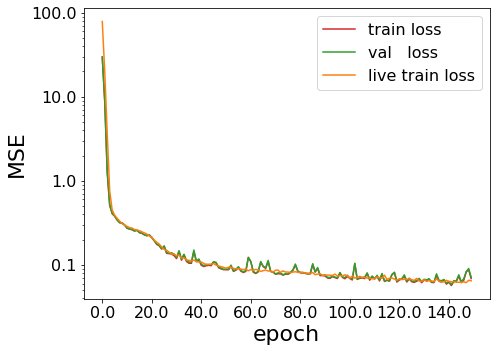

In [44]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

c1 = 'tab:red'
c2 = 'tab:green'
c3 = 'tab:orange'

axs.plot(trn_losses, label="train loss", color=c1)
axs.plot(val_losses, label="val   loss", color=c2)
axs.plot(trn_losses_live, label="live train loss", color=c3)

axs.set_yscale('log')

axs.set_xlabel("epoch", fontproperties=axislabelfont)
axs.set_ylabel("MSE", fontproperties=axislabelfont)

xticks = axs.get_xticks()
axs.set_xticklabels(xticks, fontproperties=tickfont)

yticks = axs.get_yticks()
axs.set_yticklabels(yticks, fontproperties=tickfont)

axs.legend(loc='best', prop=tickfont)

fig.tight_layout()

We can see that both the train and validation losses are being reduced during training, the model is fitting well!

We haven't used the test data here.  The test data becomes useful if our neural network overfits the training data, and we want to stop training the network early.  In this case we use the validation data to decide at which epoch to stop training, based on some early stopping condition.  For example, if the validation loss does not improve for 10 epochs, we might decide to stop training.  If we have saved the network at certain epochs during training, we would then select the network with the smallest validation loss to use.  The test data is then the final dataset we test on, since it was not used during training or in the early stopping procedure.

## Study the results

Now we want to get some visualisation of how well our amplitude regression has worked.

The simplest thing we can do is to pass our data through the neural network to get a predicted amplitude for each event, then histogram this and compare it to the histogram of the true amplitudes.

In [45]:
def get_amps(model, dataloader):
    
    amps = []

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            amps += [a.item() for a in model(X)]

    return amps

In [46]:
pred_trn_ampls = get_amps(model, trn_dataloader)
pred_val_ampls = get_amps(model, val_dataloader)

First for the training data:

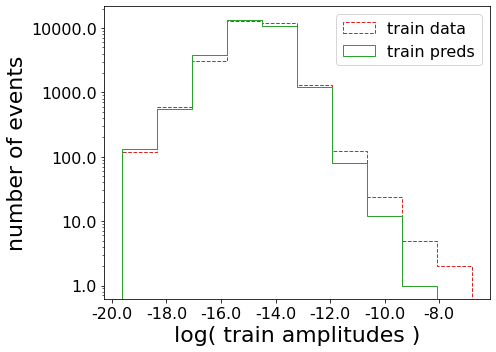

In [47]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

c1 = 'tab:red'
c2 = 'tab:green'

(n1, bins, patches1) = axs.hist(trn_ampl, histtype='stepfilled', fill=None, edgecolor=c1, label="train data", ls="--")
(n2, _, patches2) = axs.hist(pred_trn_ampls, histtype='stepfilled', fill=None, edgecolor=c2, label="train preds", bins=bins)

axs.set_yscale('log')

axs.set_xlabel("log( train amplitudes )", fontproperties=axislabelfont)
axs.set_ylabel("number of events", fontproperties=axislabelfont)

xticks = axs.get_xticks()
axs.set_xticklabels(xticks, fontproperties=tickfont)

yticks = axs.get_yticks()
axs.set_yticklabels(yticks, fontproperties=tickfont)

axs.legend(loc='best', prop=tickfont)

fig.tight_layout()

In [48]:
# matplotlib.rcParams["text.usetex"] = True # does not work on colab

We can also try to visualise the error on the predicted amplitudes by plotting $\text{abs}\left((A_{\text{true}}-A_{\text{pred}})/A_{\text{true}} \right)$.

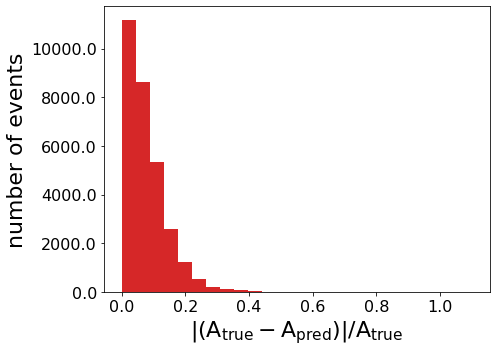

In [49]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

c1 = 'tab:red'
c2 = 'tab:green'

axs.hist(np.abs((trn_ampl-pred_trn_ampls)/trn_ampl), color=c1, bins=25)

axs.set_xlabel(f"$|(A_{{true}}-A_{{pred}})|/A_{{true}}$", fontproperties=axislabelfont)
axs.set_ylabel("number of events", fontproperties=axislabelfont)

xticks = np.round(axs.get_xticks(), 2)
axs.set_xticklabels(xticks, fontproperties=tickfont)

yticks = np.round(axs.get_yticks(), 2)
axs.set_yticklabels(yticks, fontproperties=tickfont)

fig.tight_layout()

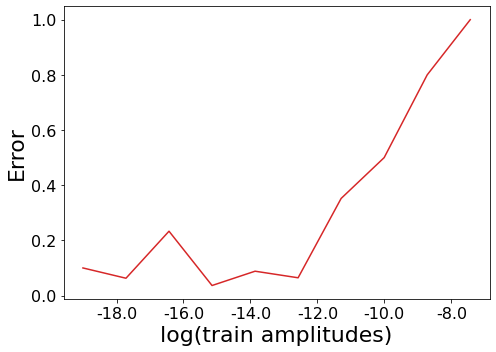

In [50]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

c1 = 'tab:red'
c2 = 'tab:green'

axs.plot((bins[1:]+bins[:-1])/2., np.abs((n1-n2)/n1), color=c1)

axs.set_xlabel("log(train amplitudes)", fontproperties=axislabelfont)
axs.set_ylabel("Error", fontproperties=axislabelfont)

xticks = np.round(axs.get_xticks(), 2)
axs.set_xticklabels(xticks, fontproperties=tickfont)

yticks = np.round(axs.get_yticks(), 2)
axs.set_yticklabels(yticks, fontproperties=tickfont)

fig.tight_layout()

The error is lowest in the regions where there is more training data, this is expected.  The more data the network has to learn from, the better it can learn to predict the correct amplitude.

And then for the validation data:

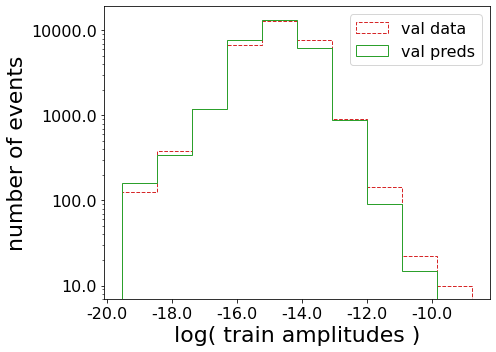

In [51]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

c1 = 'tab:red'
c2 = 'tab:green'

(n1, bins, patches1) = axs.hist(val_ampl, histtype='stepfilled', fill=None, edgecolor=c1, label="val data", ls="--")
(n2, _, patches2) = axs.hist(pred_val_ampls, histtype='stepfilled', fill=None, edgecolor=c2, label="val preds", bins=bins)

axs.set_yscale('log')

axs.set_xlabel("log( train amplitudes )", fontproperties=axislabelfont)
axs.set_ylabel("number of events", fontproperties=axislabelfont)

xticks = axs.get_xticks()
axs.set_xticklabels(xticks, fontproperties=tickfont)

yticks = axs.get_yticks()
axs.set_yticklabels(yticks, fontproperties=tickfont)

axs.legend(loc='best', prop=tickfont)

fig.tight_layout()

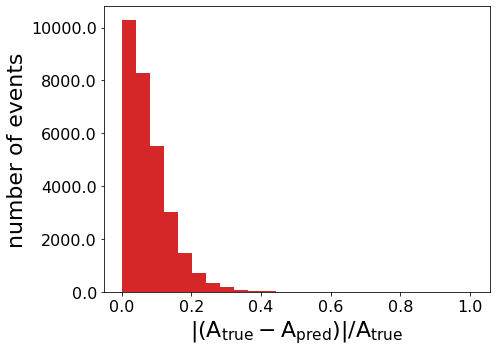

In [52]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

c1 = 'tab:red'
c2 = 'tab:green'

axs.hist(np.abs((val_ampl-pred_val_ampls)/val_ampl), color=c1, bins=25)

axs.set_xlabel(f"$|(A_{{true}}-A_{{pred}})|/A_{{true}}$", fontproperties=axislabelfont)
axs.set_ylabel("number of events", fontproperties=axislabelfont)

xticks = np.round(axs.get_xticks(), 2)
axs.set_xticklabels(xticks, fontproperties=tickfont)

yticks = np.round(axs.get_yticks(), 2)
axs.set_yticklabels(yticks, fontproperties=tickfont)

fig.tight_layout()

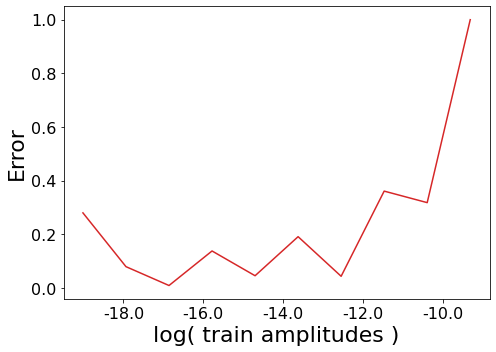

In [53]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

c1 = 'tab:red'
c2 = 'tab:green'

axs.plot((bins[1:]+bins[:-1])/2., np.abs((n1-n2)/n1), color=c1)

axs.set_xlabel("log( train amplitudes )", fontproperties=axislabelfont)
axs.set_ylabel("Error", fontproperties=axislabelfont)

xticks = np.round(axs.get_xticks(), 2)
axs.set_xticklabels(xticks, fontproperties=tickfont)

yticks = np.round(axs.get_yticks(), 2)
axs.set_yticklabels(yticks, fontproperties=tickfont)

fig.tight_layout()

## Improvements?

General ways to improve ML analyses:
- more data
- larger network
- longer training
- better optimization

What about improvements that could be made specific to this physics example?

We could take advantage of the physical symmetries in the problem:
- permutation invariance of:
    - initial gluons
    - outgoing photons
- azimuthal symmetry of the amplitude due to alignment of initial gluons